In [1]:
import mne
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import joblib

# Data direction
data_dir = 'data_competition/total'

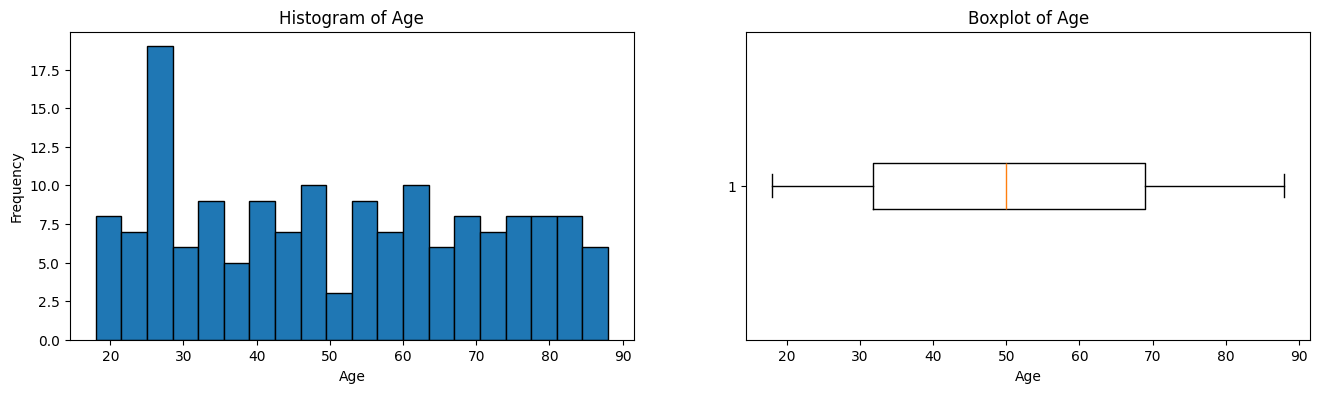

In [2]:
# Visualize Age Distribution
age_df = pd.read_csv(os.path.join(data_dir,'filtered_subjects_with_age.tsv'), sep='\t')

plt.figure(figsize=(16, 4))
# Histogram
plt.subplot(1,2,1)
plt.hist(age_df['age'], bins=20, edgecolor='black')
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
# Boxplot
plt.subplot(1,2,2)
plt.boxplot(age_df['age'], vert=False)
plt.title('Boxplot of Age')
plt.xlabel('Age')
plt.show()

In [3]:
# Define a load data function and extract features
def load_eeg_data_and_extract_features(file_path):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    misc_channels = raw.copy().pick_types(misc=True)
    data = misc_channels.get_data()

    # Simple averaging of time series as features
    avg_feature = np.mean(data,axis=1)

    return avg_feature

# Define a function to get the subject ID from file name
def get_subject_id(file_name):
    return file_name.split('-')[1].split('_')[0]

# Load all data
all_features = []
all_subjects = []
for filename in os.listdir(data_dir):
    if filename.endswith('.fif'):
        file_path = os.path.join(data_dir, filename)
        features = load_eeg_data_and_extract_features(file_path)
        subject_id = get_subject_id(filename)
        
        all_features.append(features)
        all_subjects.append(subject_id)
        
all_features = np.array(all_features)
all_subjects = np.array(all_subjects)

print(len(all_features))
print(len(all_subjects))

# Convert into df
features_df = pd.DataFrame({'subject': all_subjects, 'features': list(all_features)})
print("features_df head:")
print(features_df.head())


Opening raw data file data_competition/total\sub-CC110033_sflip_parc-raw.fif...
    Range : 16750 ... 160249 =     67.000 ...   640.996 secs
Ready.
Reading 0 ... 143499  =      0.000 ...   573.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Opening raw data file data_competition/total\sub-CC110037_sflip_parc-raw.fif...
    Range : 5000 ... 145499 =     20.000 ...   581.996 secs
Ready.
Reading 0 ... 140499  =      0.000 ...   561.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Opening raw data file data_competition/total\sub-CC110045_sflip_parc-raw.fif...
    Range : 24000 ... 164499 =     96.000 ...   657.996 secs
Ready.
Reading 0 ... 140499  =      0.000 ...   561.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Opening raw data file data_competition/total\sub-CC110056_sflip_parc-raw.fif...
    Range : 3750 ... 143999 =     15.000 ...   575.996 secs
Ready.
Reading 

In [4]:
# Define labels_df (aka aga_df, we just rename)
labels_df = age_df

# Checking
print(labels_df.head())

  participant_id  age
0   sub-CC110033   24
1   sub-CC110037   18
2   sub-CC110045   24
3   sub-CC110056   22
4   sub-CC110069   28


In [5]:
# Rename participant_id to subject
labels_df = labels_df.rename(columns={'participant_id':'subject'})

# Remove 'sub-' prefix from subject column
labels_df['subject'] = labels_df['subject'].str.replace('sub-', '', regex=False)

# Checking
print(labels_df.head())

    subject  age
0  CC110033   24
1  CC110037   18
2  CC110045   24
3  CC110056   22
4  CC110069   28


In [6]:
# Merge with labels dataframe
merged_df = pd.merge(features_df, labels_df, on='subject')
merged_df.head()

,subject,features,age
0,CC110033,"[1.5624802079350276e-11, -9.583347573963996e-1...",24
1,CC110037,"[-2.994624393647437e-10, -9.79894381911358e-11...",18
2,CC110045,"[1.598513355340686e-10, 1.2426856663820685e-10...",24
3,CC110056,"[-3.9270151857454364e-10, -1.191684871218076e-...",22
4,CC110069,"[3.2031036241417517e-10, -7.116818697824809e-1...",28


In [7]:
# Prepare train and test dataset
subjects = merged_df['subject'].tolist()
labels = merged_df['age'].tolist()
features = np.array(merged_df['features'].tolist())

np.random.seed(42) # Set random seed
test_size = 40 # Randomly select 40 subjects for testing
test_indices = np.random.choice(len(subjects), test_size, replace=False)

train_indices = [i for i in range(len(subjects)) if i not in test_indices]

X_train = features[train_indices]
y_train = np.array(labels)[train_indices]
X_test = features[test_indices]
y_test = np.array(labels)[test_indices]

# Shape checking
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (120, 52)
Shape of y_train: (120,)
Shape of X_test: (40, 52)
Shape of y_test: (40,)


In [8]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Prediction
y_pred_lr = lr_model.predict(X_test_scaled)

# Mean Absolute Error (MAE)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(f"Linear Regression MAE: {mae_lr:.2f} years")

# Mean Squared Error (MSE)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"Linear Regression MSE: {mse_lr:.2f}")

# R-squared (R2)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression R2: {r2_lr:.2f}")

Linear Regression MAE: 20.10 years
Linear Regression MSE: 655.08
Linear Regression R2: -0.67


In [10]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=250, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

# Compute metrics like Linear Regression
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest MAE: {mae_rf:.2f} years")

mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf:.2f}")

r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest R2: {r2_rf:.2f}")


Random Forest MAE: 17.08 years
Random Forest MSE: 393.41
Random Forest R2: -0.00


In [11]:
# Support Vector Regression (SVR)
svr_model = SVR(C=1, gamma='scale', kernel='rbf')
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)

# Compute metrics like Linear Regression
mae_svr = mean_absolute_error(y_test, y_pred_svr)
print(f"SVR MAE: {mae_svr:.2f} years")

mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"SVR MSE: {mse_svr:.2f}")

r2_svr = r2_score(y_test, y_pred_svr)
print(f"SVR R2: {r2_svr:.2f}")


SVR MAE: 16.98 years
SVR MSE: 390.44
SVR R2: 0.00


In [12]:
# XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.001, max_depth=5, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Compute metrics like Linear Regression
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost MAE: {mae_xgb:.2f} years")

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost MSE: {mse_xgb:.2f}")

r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost R2: {r2_xgb:.2f}")

XGBoost MAE: 17.00 years
XGBoost MSE: 394.46
XGBoost R2: -0.01


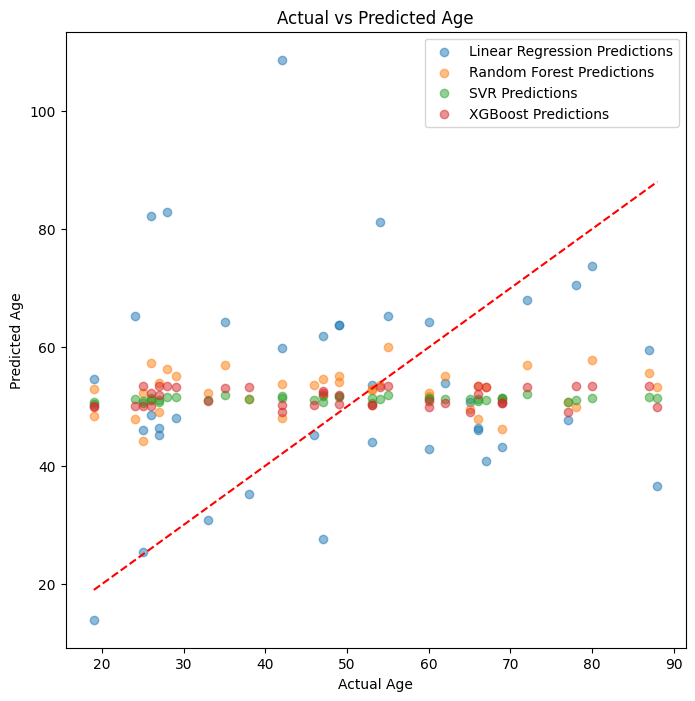

In [13]:
# Visualize the predictions against actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_lr, label='Linear Regression Predictions', alpha=0.5)
plt.scatter(y_test, y_pred_rf, label='Random Forest Predictions', alpha=0.5)
plt.scatter(y_test, y_pred_svr, label='SVR Predictions', alpha=0.5)
plt.scatter(y_test, y_pred_xgb, label='XGBoost Predictions', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line of perfect prediction
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("Actual vs Predicted Age")
plt.legend()
plt.show()